In [1]:
from pandas_datareader import data as wb
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import threading
import time
import csv
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, CuDNNLSTM
from stockstats import StockDataFrame as sdf
from matplotlib import pyplot as plt
from pylab import rcParams
from textblob import TextBlob
from selenium import webdriver
from sklearn import preprocessing
from collections import deque

In [ ]:
cur_eval = 0

eval_dict = {
    0 : 'Bad',
    1 : 'Good',
    None : 'Neutral'
}

k = 1
site = 'https://finance.yahoo.com'
tickers = ['AAPL', 'F', 'NFLX', 'MSFT', 'TSLA']

ticker_dict = {
    'AAPL' : 'Apple',
    'F' : 'Ford',
    'NFLX' : 'Netflix',
    'MSFT' : 'Microsoft',
    'TSLA' : 'Tesla'
}

print('COMPANIES')
print('0 : AAPL (Apple)')
print('1 : F (Ford)')
print('2 : NFLX (Netflix)')
print('3 : MSFT (Microsoft)')
print('4 : TSLA (Tesla)\n')
val = int(float(input('This function gets the most recent sentiment on a specific company. Enter an integer: ')))
cur_ticker = tickers[val]
name = ticker_dict.get(cur_ticker)
print('You chose:\n{0} : {1} ({2})\n'.format(str(val), cur_ticker, name))
driver = webdriver.Firefox(executable_path='./geckodriver')
driver.get(site)

try:
    driver.find_element_by_xpath('//button[@name="agree"]').click()
except:
    pass

for scroll in range(20):
    driver.execute_script('window.scrollBy(0, 2000)')
    time.sleep(2)

link_elems = driver.find_elements_by_xpath('//ul/li/div/div/div/h3/a')

for elem in link_elems:
    if 'finance.yahoo' in elem.get_attribute('href'):
        if name.upper() in elem.text.upper():
            print('Article name: ' + elem.text)
            driver2 = webdriver.Firefox(executable_path='./geckodriver')
            driver2.get(elem.get_attribute('href'))

            try:
                driver2.find_element_by_xpath('//button[@name="agree"]').click()
            except:
                pass

            print('Yahoo Finance {0} article #{1} opened.'.format(name, k))
            article_text = driver2.find_elements_by_xpath('//article/div/p')
            file = open('current_text.txt', 'w')

            for p in article_text:
                if p.get_attribute('content')[:7] == '<a href':
                    break
                file.write(p.text+' ')

            file.close()
            file = open('current_text.txt', 'r')

            polarity = TextBlob(file.read()).sentiment.polarity

            if polarity < 0:
                eval_int = 0
                cur_eval -= 1
            elif polarity > 0:
                eval_int = 1
                cur_eval += 1
            else:
                eval_int = None

            print('{0} article #{1} sentiment: {2}.\n'.format(name, str(k), eval_dict.get(eval_int)))
            k += 1

            file.close()
            driver2.close()

driver.close()
file = open('current_text.txt', 'w')
file.close()
            
if cur_eval > 0:
    overall_eval_int = 1
elif cur_eval < 0:
    overall_eval_int = 0
else:
    overall_eval_int = None

print('Current {0} sentiment: {1}.'.format(name, eval_dict.get(overall_eval_int)))

--------------

In [2]:
def evaluate_price(f, c):
    if f > c:
        return 1
    else:
        return 0

In [3]:
seq_length = 60 #no. of days in training iterations
target_length = 3 #no. of days ahead

In [7]:
stock_data = wb.DataReader(cur_ticker, data_source='yahoo', start='1900-1-1')

In [8]:
indicators = sdf.retype(stock_data)
indicators['boll']
indicators['boll_ub']
indicators['boll_lb']
indicators['macd']
stock_data['future'] = stock_data['close'].shift(-target_length)
stock_data['eval'] = list(map(evaluate_price, stock_data['future'], stock_data['close']))
del stock_data['future']

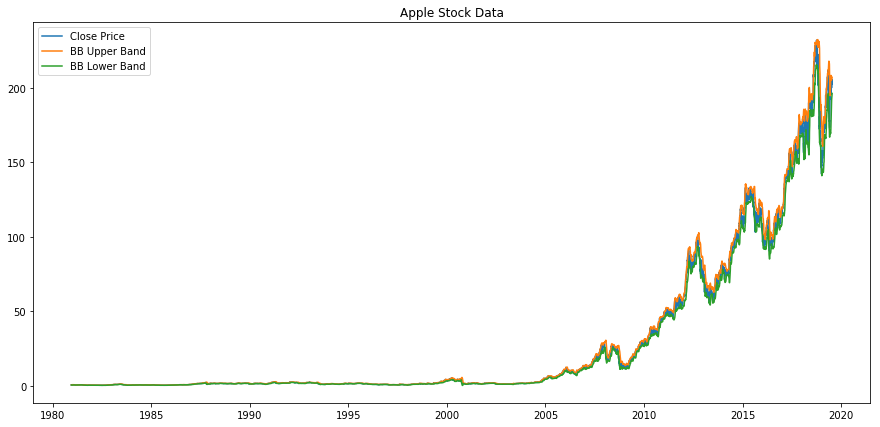

In [9]:
rcParams['figure.figsize'] = 15, 7
plt.plot(stock_data['close'], label='Close Price')
plt.plot(stock_data['boll_ub'], label='BB Upper Band')
plt.plot(stock_data['boll_lb'], label='BB Lower Band')
plt.title('{0} Stock Data'.format(name))
plt.legend()
plt.show()

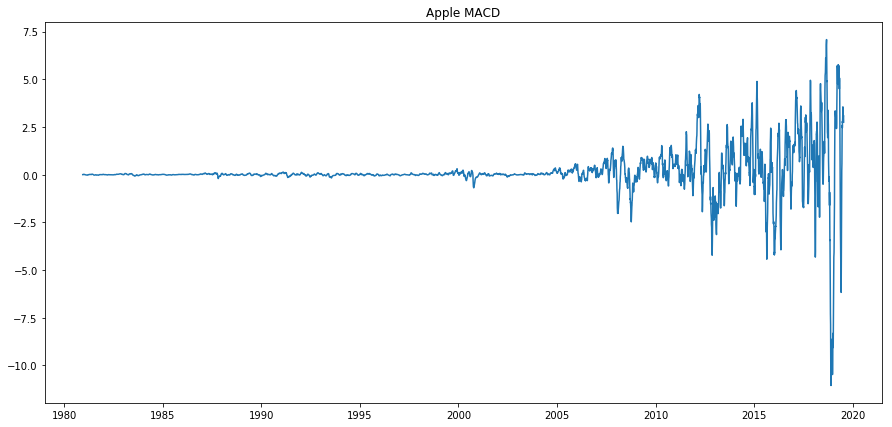

In [10]:
rcParams['figure.figsize'] = 15, 7
plt.plot(stock_data['macd'], label='MACD')
plt.title(name+' MACD')
plt.show()

--------

In [11]:
time_stamps = sorted(stock_data.index.values)
last_five_pct = time_stamps[-int(0.05*len(stock_data.index))]

In [12]:
training_data = stock_data[(stock_data.index < last_five_pct)]
testing_data = stock_data[(last_five_pct <= stock_data.index)]

In [13]:
def preprocess_data(dataframe):
    df = pd.DataFrame(dataframe)
    
    for col in df.columns:
        if col != 'eval':
            df[col] = df[col].pct_change()
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
    
    df.dropna(inplace=True)
    seq_data = []
    prev_days = deque(maxlen=seq_length)
    
    for i in df.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == seq_length:
            seq_data.append([np.array(prev_days), i[-1]])
    
    random.shuffle(seq_data)
    
    sells = []
    buys = []
    
    for seq, eva in seq_data:
        if eva == 0:
            sells.append([seq, eva])
        elif eva == 1:
            buys.append([seq, eva])
            
    limit = min(len(sells), len(buys))
    buys = buys[:limit]
    sells = sells[:limit]
    
    seq_data = sells + buys
    random.shuffle(seq_data)
    
    X = []
    y = []
    
    for seq, eva in seq_data:
        X.append(seq)
        y.append(eva)
        
    return np.array(X), y

In [14]:
x_train, y_train = preprocess_data(training_data)

In [15]:
x_test, y_test = preprocess_data(testing_data)

In [16]:
print(f'Train data: {len(x_train)}. Test data: {len(x_test)}')
print(f'Train sells: {y_train.count(0)}. Buys: {y_train.count(1)}')
print(f'Test sells: {y_test.count(0)}. Buys: {y_test.count(1)}')

Train data: 8954. Test data: 376
Train sells: 4477. Buys: 4477
Test sells: 188. Buys: 188


---------------------

In [ ]:
#model = Sequential()

In [ ]:
#model.add(CuDNNLSTM(128, input_shape=(stock_data['close'].shape), return_sequences=True))

In [ ]:
#model.add(Dropout(0.2))

In [ ]:
#model.add(CuDNNLSTM(128))

In [ ]:
#model.add(Dropout(0.2))

In [ ]:
#model.add(Dense(22, activation='relu'))

In [ ]:
#model.add(Dropout(0.2))

In [ ]:
#model.add(Dense(2, activation='softmax'))

In [ ]:
#opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

In [ ]:
#model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
#model.fit(predictions, stock_data['close'], epochs=3, validation_data=)